<a href="https://colab.research.google.com/github/Mike-Mans/C-SQL-CS008-Final-Project/blob/main/archived/math_156_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install datasets torch torchvision torchaudio numpy pandas scikit-learn librosa optuna matplotlib seaborn tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 14.7 MB/s eta 0:00:00


In [ ]:
!wget https://huggingface.co/datasets/google/speech_commands/resolve/main/speech_commands.py

--2025-11-20 02:04:14--  https://huggingface.co/datasets/google/speech_commands/resolve/main/speech_commands.py
Resolving huggingface.co (huggingface.co)... 3.165.160.12, 3.165.160.59, 3.165.160.61, ...
Connecting to huggingface.co (huggingface.co)|3.165.160.12|:443... connected.
HTTP request sent, awaiting response... 307 Temporary Redirect
Location: /api/resolve-cache/datasets/google/speech_commands/57ba463ab37e1e7845e0626539a6f6d0fcfbe64a/speech_commands.py?%2Fdatasets%2Fgoogle%2Fspeech_commands%2Fresolve%2Fmain%2Fspeech_commands.py=&etag=%22a7d6c44c469bcd15ec0a0ddecfa5d509a2eed812%22 [following]
--2025-11-20 02:04:14--  https://huggingface.co/api/resolve-cache/datasets/google/speech_commands/57ba463ab37e1e7845e0626539a6f6d0fcfbe64a/speech_commands.py?%2Fdatasets%2Fgoogle%2Fspeech_commands%2Fresolve%2Fmain%2Fspeech_commands.py=&etag=%22a7d6c44c469bcd15ec0a0ddecfa5d509a2eed812%22
Reusing existing connection to huggingface.co:443.
HTTP request sent, awaiting response... 200 OK
Length:

In [ ]:
import os
import torch
import torchvision
import torchaudio
import numpy as np
import pandas as pd
import sklearn
import librosa
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import glob
import torch.nn as nn

In [ ]:
# define target classes mapping
CORE_COMMANDS = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
UNKNOWN_WORDS = ['bed', 'cat', 'dog', 'eight', 'five', 'four', 'happy', 'house', 'marvin', 'nine',
                 'one', 'seven', 'sheila', 'six', 'three', 'tree', 'two', 'wow', 'zero']

def get_label(word_class):
    """
    Map word class to numerical label for 12-class classification.
    Returns:
        0-9: Core command indices
        10: Unknown class (all auxiliary words)
        11: Silence class
    """
    if word_class in CORE_COMMANDS:
        return CORE_COMMANDS.index(word_class)
    elif word_class in UNKNOWN_WORDS:
        return 10  # unknown
    elif word_class == '_silence_':
        return 11  # silence
    else:
        return 10  # default to unknown

In [ ]:
def create_silence_data():
    """
    Create silence data by slicing background noise files into 1-second chunks.

    Iterates through the long audio files in the _background_noise_ directory,
    slices them into 1-second (16,000 samples) chunks at 16kHz, and saves these chunks
    as individual WAV files in a _silence_ directory.

    Returns:
        List of paths to the generated silence audio files.
    """

    silence_dir = os.path.join(DATASET_PATH, "SpeechCommands", "speech_commands_v0.02", "_silence_")
    background_noise_dir = os.path.join(DATASET_PATH, "SpeechCommands", "speech_commands_v0.02", "_background_noise_")

    # creates silence directory if it doesn't exist
    os.makedirs(silence_dir, exist_ok=True)

    silence_files = []

    # gets all WAV files in background noise directory
    background_files = glob.glob(os.path.join(background_noise_dir, "*.wav"))

    chunk_counter = 0

    for bg_file in background_files:
        # load the background noise file
        waveform, sample_rate = torchaudio.load(bg_file)

        # ensure sample rate is 16kHz
        assert sample_rate == 16000, f"Expected 16kHz sample rate, got {sample_rate}"

        # get the waveform data
        if waveform.shape[0] > 1:
            waveform = waveform[0:1, :]  # take first channel if multi-channel

        waveform = waveform.squeeze()  # remove channel dimension for easier processing
        total_samples = waveform.shape[0]

        # calculate number of 1-second chunks (16000 samples each)
        chunk_size = 16000
        num_chunks = total_samples // chunk_size

        # slice the waveform into chunks
        for i in range(num_chunks):
            start_sample = i * chunk_size
            end_sample = start_sample + chunk_size

            chunk = waveform[start_sample:end_sample]

            # save chunk
            chunk_filename = f"silence_{chunk_counter:05d}.wav"
            chunk_path = os.path.join(silence_dir, chunk_filename)

            # save as mono WAV file
            torchaudio.save(chunk_path, chunk.unsqueeze(0), sample_rate)

            silence_files.append(chunk_path)
            chunk_counter += 1

    print(f"created {len(silence_files)} silence chunks from {len(background_files)} background noise files")
    return silence_files

In [ ]:
def load_dataset_splits():
    """
    Load the validation and testing lists and create three master lists of file paths.

    Returns:
        train_files: List of file paths for training (all files not in validation/testing + 80% of silence)
        val_files: List of file paths for validation (files from validation_list.txt + 10% of silence)
        test_files: List of file paths for testing (files from testing_list.txt + 10% of silence)
    """
    dataset_dir = os.path.join(DATASET_PATH, "SpeechCommands", "speech_commands_v0.02")

    # load validation and testing lists
    with open(os.path.join(dataset_dir, 'validation_list.txt'), 'r') as f:
        val_lines = f.read().splitlines()
    with open(os.path.join(dataset_dir, 'testing_list.txt'), 'r') as f:
        test_lines = f.read().splitlines()

    # convert to sets for faster lookup
    val_files_set = set(val_lines)
    test_files_set = set(test_lines)

    # get all WAV files in the dataset
    all_wav_files = []
    for root, dirs, files in os.walk(dataset_dir):
        for file in files:
            if file.endswith('.wav'):
                # Get relative path from dataset directory
                rel_path = os.path.relpath(os.path.join(root, file), dataset_dir)
                all_wav_files.append(rel_path)

    # create train/val/test file lists
    train_files = []
    val_files = []
    test_files = []

    for wav_file in all_wav_files:
        if wav_file in val_files_set:
            val_files.append(os.path.join(dataset_dir, wav_file))
        elif wav_file in test_files_set:
            test_files.append(os.path.join(dataset_dir, wav_file))
        else:
            train_files.append(os.path.join(dataset_dir, wav_file))

    # handle silence files partitioning (80% train, 10% val, 10% test)
    silence_dir = "_silence_"
    if os.path.exists(silence_dir):
        silence_files = glob.glob(os.path.join(silence_dir, "*.wav"))
        silence_files.sort()  # sort for reproducible splits

        n_silence = len(silence_files)
        n_train_silence = int(0.8 * n_silence)
        n_val_silence = int(0.1 * n_silence)

        train_files.extend(silence_files[:n_train_silence])
        val_files.extend(silence_files[n_train_silence:n_train_silence + n_val_silence])
        test_files.extend(silence_files[n_train_silence + n_val_silence:])

    print(f"Dataset splits created:")
    print(f"  Training: {len(train_files)} files")
    print(f"  Validation: {len(val_files)} files")
    print(f"  Testing: {len(test_files)} files")

    return train_files, val_files, test_files

In [ ]:
DATASET_PATH = "./speech_commands_v2"
os.makedirs(DATASET_PATH, exist_ok=True)

train_dataset = torchaudio.datasets.SPEECHCOMMANDS(
    root=DATASET_PATH,
    folder_in_archive="SpeechCommands",
    download=True,
    subset="training",
)

test_dataset = torchaudio.datasets.SPEECHCOMMANDS(
    root=DATASET_PATH,
    folder_in_archive="SpeechCommands",
    download=True,
    subset="testing",
)

valid_dataset = torchaudio.datasets.SPEECHCOMMANDS(
    root=DATASET_PATH,
    folder_in_archive="SpeechCommands",
    download=True,
    subset="validation",
)

100%|██████████| 2.26G/2.26G [00:24<00:00, 101MB/s]


In [ ]:
create_silence_data()

/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

created 398 silence chunks from 6 background noise files


['./speech_commands_v2/SpeechCommands/speech_commands_v0.02/_silence_/silence_00000.wav',
 './speech_commands_v2/SpeechCommands/speech_commands_v0.02/_silence_/silence_00001.wav',
 './speech_commands_v2/SpeechCommands/speech_commands_v0.02/_silence_/silence_00002.wav',
 './speech_commands_v2/SpeechCommands/speech_commands_v0.02/_silence_/silence_00003.wav',
 './speech_commands_v2/SpeechCommands/speech_commands_v0.02/_silence_/silence_00004.wav',
 './speech_commands_v2/SpeechCommands/speech_commands_v0.02/_silence_/silence_00005.wav',
 './speech_commands_v2/SpeechCommands/speech_commands_v0.02/_silence_/silence_00006.wav',
 './speech_commands_v2/SpeechCommands/speech_commands_v0.02/_silence_/silence_00007.wav',
 './speech_commands_v2/SpeechCommands/speech_commands_v0.02/_silence_/silence_00008.wav',
 './speech_commands_v2/SpeechCommands/speech_commands_v0.02/_silence_/silence_00009.wav',
 './speech_commands_v2/SpeechCommands/speech_commands_v0.02/_silence_/silence_00010.wav',
 './speech

In [ ]:
train_files, val_files, test_files = load_dataset_splits()

Dataset splits created:
  Training: 85247 files
  Validation: 9981 files
  Testing: 11005 files


In [ ]:
train_files

['./speech_commands_v2/SpeechCommands/speech_commands_v0.02/yes/8f811bbc_nohash_0.wav',
 './speech_commands_v2/SpeechCommands/speech_commands_v0.02/yes/ac4b3fc3_nohash_1.wav',
 './speech_commands_v2/SpeechCommands/speech_commands_v0.02/yes/7d5f87c8_nohash_1.wav',
 './speech_commands_v2/SpeechCommands/speech_commands_v0.02/yes/3847619e_nohash_1.wav',
 './speech_commands_v2/SpeechCommands/speech_commands_v0.02/yes/23059a35_nohash_0.wav',
 './speech_commands_v2/SpeechCommands/speech_commands_v0.02/yes/195c120a_nohash_2.wav',
 './speech_commands_v2/SpeechCommands/speech_commands_v0.02/yes/fbb56351_nohash_4.wav',
 './speech_commands_v2/SpeechCommands/speech_commands_v0.02/yes/5ebc1cda_nohash_4.wav',
 './speech_commands_v2/SpeechCommands/speech_commands_v0.02/yes/e6327279_nohash_0.wav',
 './speech_commands_v2/SpeechCommands/speech_commands_v0.02/yes/69a1a79f_nohash_0.wav',
 './speech_commands_v2/SpeechCommands/speech_commands_v0.02/yes/cd7f8c1b_nohash_0.wav',
 './speech_commands_v2/SpeechCom

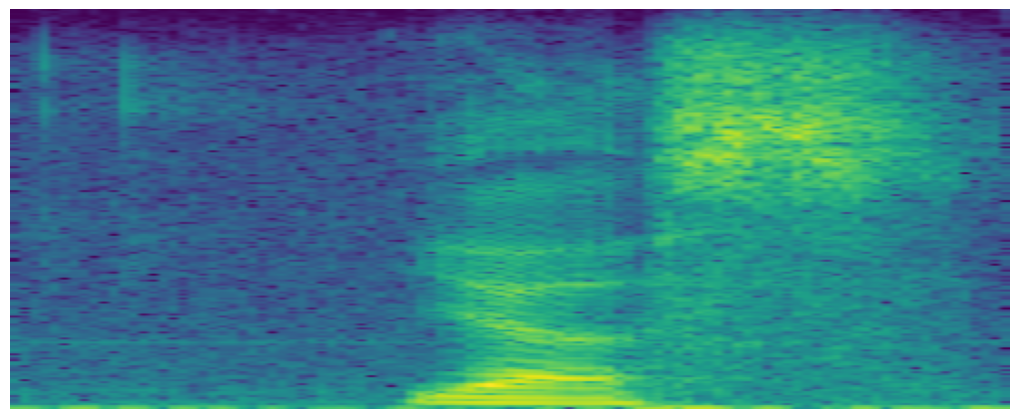

In [ ]:
# convert data to mel spectrograms via torchaudio packages
import torch
import torchaudio
import matplotlib.pyplot as plt

# 1. Load the audio waveform
# For demonstration, we'll create a dummy waveform.
# In a real application, you would load from a file:
# waveform, sample_rate = torchaudio.load("path/to/your/audio.wav")
duration = 1  # seconds
waveform,sample_rate = torchaudio.load(train_files[0])
t = torch.linspace(0, duration, int(sample_rate * duration), dtype=torch.float32)


# 2. Define the Spectrogram transformation
# n_fft: size of the FFT window
# hop_length: number of samples between successive frames
# power: 2 for power spectrogram, 1 for magnitude spectrogram
spectrogram_transform = torchaudio.transforms.Spectrogram(
    n_fft=400,  # Example: 25ms window at 16kHz
    hop_length=160, # Example: 10ms hop
    power=2,    # Power spectrogram
)

# 3. Apply the Spectrogram transformation
spectrogram = spectrogram_transform(waveform)

# 4. Convert to log-magnitude
# Add a small epsilon to avoid log(0)
log_spectrogram = torch.log(spectrogram + 1e-8)

# 5. (Optional) Visualize the log spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(log_spectrogram.squeeze(0).numpy(), aspect='auto', origin='lower', cmap='viridis')
# plt.title("Log-Magnitude Spectrogram")
# plt.xlabel("Time Frames")
# plt.ylabel("Frequency Bins")
# plt.colorbar(format="%+2.0f dB")

plt.axis('off')


plt.tight_layout(pad=0)

# To remove the huge white borders
plt.margins(0)

plt.savefig('foo.png')

In [ ]:
def wav_to_png(wav_path,png_path):
  duration = 1  # seconds
  waveform,sample_rate = torchaudio.load(wav_path)
  t = torch.linspace(0, duration, int(sample_rate * duration), dtype=torch.float32)
  spectrogram_transform = torchaudio.transforms.Spectrogram(
    n_fft=400,  # Example: 25ms window at 16kHz
    hop_length=160, # Example: 10ms hop
    power=2,    # Power spectrogram
  )
  log_spectrogram = torch.log(spectrogram + 1e-8)
  plt.figure(figsize=(10, 4))
  plt.imshow(log_spectrogram.squeeze(0).numpy(), aspect='auto', origin='lower', cmap='Greys')
  plt.axis('off')
  plt.tight_layout(pad=0)
  plt.margins(0)
  plt.savefig(png_path)
  ####


In [ ]:
!mkdir imgs2
for i,img_path in enumerate(train_files[:100]):
  if i%25==0:
    print(i)
  wav_to_png(img_path,'./imgs2/'+str(i))

In [ ]:
import matplotlib.image as mpimg
def png_to_arr(png_path):
  return mpimg.imread(png_path)[:,:,0]
png_to_arr('./imgs2/0.png')

array([[1.        , 1.        , 1.        , ..., 0.8862745 , 0.8862745 ,
        0.8862745 ],
       [1.        , 1.        , 1.        , ..., 0.8901961 , 0.8901961 ,
        0.8901961 ],
       [1.        , 1.        , 1.        , ..., 0.9019608 , 0.9019608 ,
        0.9019608 ],
       ...,
       [0.3647059 , 0.3647059 , 0.3647059 , ..., 0.3529412 , 0.3529412 ,
        0.3529412 ],
       [0.30588236, 0.30588236, 0.30588236, ..., 0.29411766, 0.29411766,
        0.29411766],
       [0.29411766, 0.29411766, 0.29411766, ..., 0.28235295, 0.28235295,
        0.28235295]], dtype=float32)

array([[0.26666668, 0.26666668, 0.26666668, ..., 0.25490198, 0.25490198,
        0.25490198],
       [0.26666668, 0.26666668, 0.26666668, ..., 0.25490198, 0.25490198,
        0.25490198],
       [0.26666668, 0.26666668, 0.26666668, ..., 0.25882354, 0.25882354,
        0.25882354],
       ...,
       [0.27058825, 0.27058825, 0.27058825, ..., 0.2901961 , 0.2901961 ,
        0.2901961 ],
       [0.38039216, 0.38039216, 0.38039216, ..., 0.39607844, 0.39607844,
        0.39607844],
       [0.40392157, 0.40392157, 0.40392157, ..., 0.41960785, 0.41960785,
        0.41960785]], dtype=float32)

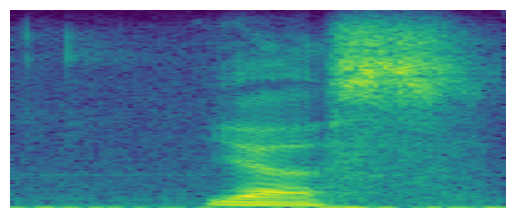

In [ ]:
import matplotlib.image as mpimg
image_path = 'foo.png'  # Replace with the actual path to your image file
img = mpimg.imread(image_path)
plt.axis('off')
plt.imshow(img)
img[:,:,0]

#i'm sorry this is messy :(
#i will clean this up later
#also i will organize all of this

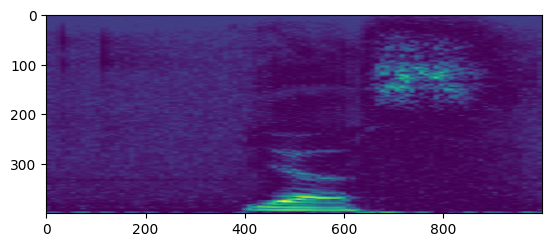

In [ ]:
plt.imshow(img[:,:,0], cmap='viridis', interpolation='nearest')

In [ ]:
fig = plt.gcf()   # get current figure (the spectrogram you just plotted)
type(fig)
#type(plt.fig)

matplotlib.figure.Figure

<Figure size 640x480 with 0 Axes>

In [ ]:
sample_rate = 16000
duration = 1  # seconds
t = torch.linspace(0, duration, int(sample_rate * duration), dtype=torch.float32)
for i in range(1000):
  waveform,sample_rate = torchaudio.load(train_files[0])
  # 2. Define the Spectrogram transformation
  # n_fft: size of the FFT window
  # hop_length: number of samples between successive frames
  # power: 2 for power spectrogram, 1 for magnitude spectrogram
  spectrogram_transform = torchaudio.transforms.Spectrogram(
      n_fft=400,  # Example: 25ms window at 16kHz
      hop_length=160, # Example: 10ms hop
      power=2,    # Power spectrogram
  )

  # 3. Apply the Spectrogram transformation
  spectrogram = spectrogram_transform(waveform)

  # 4. Convert to log-magnitude
  # Add a small epsilon to avoid log(0)
  log_spectrogram = torch.log(spectrogram + 1e-8)


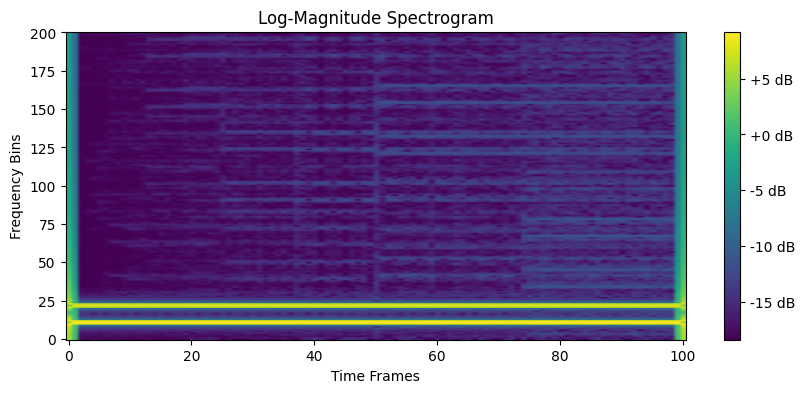

In [ ]:
import torch
import torchaudio
import matplotlib.pyplot as plt

# 1. Load the audio waveform
# For demonstration, we'll create a dummy waveform.
# In a real application, you would load from a file:
# waveform, sample_rate = torchaudio.load("path/to/your/audio.wav")
sample_rate = 16000
duration = 1  # seconds
t = torch.linspace(0, duration, int(sample_rate * duration), dtype=torch.float32)
waveform = torch.sin(2 * torch.pi * 440 * t) + 0.5 * torch.sin(2 * torch.pi * 880 * t)
waveform = waveform.unsqueeze(0) # Add a channel dimension (batch, channel, time)

# 2. Define the Spectrogram transformation
# n_fft: size of the FFT window
# hop_length: number of samples between successive frames
# power: 2 for power spectrogram, 1 for magnitude spectrogram
spectrogram_transform = torchaudio.transforms.Spectrogram(
    n_fft=400,  # Example: 25ms window at 16kHz
    hop_length=160, # Example: 10ms hop
    power=2,    # Power spectrogram
)

# 3. Apply the Spectrogram transformation
spectrogram = spectrogram_transform(waveform)

# 4. Convert to log-magnitude
# Add a small epsilon to avoid log(0)
log_spectrogram = torch.log(spectrogram + 1e-8)

# 5. (Optional) Visualize the log spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(log_spectrogram.squeeze(0).numpy(), aspect='auto', origin='lower', cmap='viridis')
plt.title("Log-Magnitude Spectrogram")
plt.xlabel("Time Frames")
plt.ylabel("Frequency Bins")
plt.colorbar(format="%+2.0f dB")
plt.show()

In [ ]:
waveform = torch.sin(2 * torch.pi * 440 * t) + 0.5 * torch.sin(2 * torch.pi * 880 * t)
#waveform=torch.
type(waveform)

torch.Tensor

In [ ]:
# data augmentation strategy:
# 1. randomly select _silence_ chunk and add to training sample at random, low SNR
# 2. randomly shift waveform left or right by small margin (100-200 ms), padding with silence
# (after transforming to 2D)
# 3. randomly mask out frequency bands using torchaudio
# 4. randomly mask time steps using torch audio

In [ ]:
# implement a custom class SpeechCommandsDataset(torch.utils.data.Dataset).
# __init__(self, file_paths, transform_pipeline, augmentation_pipeline): Stores file paths, labels, and the transform/augmentation objects.
# __getitem__(self, idx):
  # loads the .wav file at idx using torchaudio.load().
  # verifies/pads/truncates waveform to exactly 16,000 samples.
  # applies augmentations (if it's the training set).
  # applies the Mel Spectrogram transformation pipeline.
  # returns the (spectrogram_tensor, label_tensor).
import random
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

class SpeechCommandsDataset(Dataset):
    def __init__(
        self,
        file_paths,
        mode="train",
        sample_rate=16000,
        n_fft=400,
        hop_length=160,
        time_mask_param=20,
        freq_mask_param=10,
    ):
        """
        file_paths: list of .wav paths (train_files / val_files / test_files)
        mode: "train", "val", or "test" (controls augmentations)
        """
        self.file_paths = file_paths
        self.mode = mode
        self.sample_rate = sample_rate
        self.num_samples = sample_rate  # 1 second

        # Spectrogram transform (same settings as your earlier demo cell)
        self.spectrogram_transform = torchaudio.transforms.Spectrogram(
            n_fft=n_fft,
            hop_length=hop_length,
            power=2,
        )

        # Data augmentation (only used in training)
        if mode == "train":
            self.time_mask = torchaudio.transforms.TimeMasking(time_mask_param=time_mask_param)
            self.freq_mask = torchaudio.transforms.FrequencyMasking(freq_mask_param=freq_mask_param)
        else:
            self.time_mask = None
            self.freq_mask = None

    def __len__(self):
        return len(self.file_paths)

    def _load_and_fix_waveform(self, wav_path):
        """
        Loads the waveform, converts to mono, and pads/truncates to exactly self.num_samples.
        """
        waveform, sr = torchaudio.load(wav_path)

        # If needed, resample to target sample_rate
        if sr != self.sample_rate:
            waveform = torchaudio.functional.resample(waveform, sr, self.sample_rate)

        # Ensure mono (keep first channel)
        if waveform.shape[0] > 1:
            waveform = waveform[:1, :]

        # Pad or truncate to fixed length
        num_current = waveform.shape[1]
        if num_current < self.num_samples:
            pad_amount = self.num_samples - num_current
            waveform = F.pad(waveform, (0, pad_amount))
        elif num_current > self.num_samples:
            waveform = waveform[:, : self.num_samples]

        return waveform

    def _get_label_from_path(self, wav_path):
        """
        Extract the word class from the directory name and map it with get_label().
        Example:
          .../speech_commands_v0.02/yes/0a7c2a8d_nohash_0.wav -> 'yes'
          .../speech_commands_v0.02/_silence_/silence_00001.wav -> '_silence_'
        """
        word_class = os.path.basename(os.path.dirname(wav_path))  # e.g. 'yes', 'no', '_silence_'
        return get_label(word_class)

    def _random_time_shift(self, waveform, max_shift_seconds=0.2):
        """
        Randomly shift waveform left/right by up to max_shift_seconds.
        """
        max_shift = int(max_shift_seconds * self.sample_rate)
        if max_shift == 0:
            return waveform

        shift = random.randint(-max_shift, max_shift)
        if shift > 0:
            # shift right: pad on left, cut at end
            waveform = F.pad(waveform, (shift, 0))[:, :-shift]
        elif shift < 0:
            # shift left: pad on right, cut at beginning
            shift = -shift
            waveform = F.pad(waveform, (0, shift))[:, shift:]
        return waveform

    def _waveform_to_log_spectrogram(self, waveform):
        """
        Apply spectrogram transform and log-scaling.
        Output shape: [1, freq_bins, time_steps]
        """
        spectrogram = self.spectrogram_transform(waveform)
        log_spectrogram = torch.log(spectrogram + 1e-8)

        # Optional: normalize per example
        mean = log_spectrogram.mean()
        std = log_spectrogram.std()
        log_spectrogram = (log_spectrogram - mean) / (std + 1e-9)

        return log_spectrogram

    def __getitem__(self, idx):
        wav_path = self.file_paths[idx]

        # 1. Load and fix waveform length
        waveform = self._load_and_fix_waveform(wav_path)

        # 2. Data augmentation (training only)
        if self.mode == "train":
            waveform = self._random_time_shift(waveform)

        # 3. Convert to log-spectrogram
        log_spec = self._waveform_to_log_spectrogram(waveform)

        # 4. Label
        label = self._get_label_from_path(wav_path)
        label = torch.tensor(label, dtype=torch.long)

        return log_spec, label

In [ ]:
# initialize pytorch dataloaders
# instantiate three DataLoader objects (train, val, test) from Dataset instances
# train_loader: shuffle=True, batch_size, num_workers (for parallel loading)
# val_loader & test_loader: shuffle=False, same batch_size, num_workers.

# Hyperparameters for loading
batch_size = 64
num_workers = 2  # adjust depending on your machine

# Create Dataset instances
train_dataset = SpeechCommandsDataset(train_files, mode="train")
val_dataset   = SpeechCommandsDataset(val_files,   mode="val")
test_dataset  = SpeechCommandsDataset(test_files,  mode="test")

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
)

len(train_dataset), len(val_dataset), len(test_dataset)

(85247, 9981, 11005)

In [ ]:
class ShallowSpeechCNN(nn.Module):
    """
    A shallow CNN consisting of two convolutional blocks
    followed by two fully connected layers.
    """
    def __init__(self, num_classes):
        """
        initializes the layers of the neural network

        Args:
            num_classes (int): The number of output classes
        """
        super(ShallowSpeechCNN, self).__init__()

        # conv block 1
        # input shape: (batch_size, 1, n_mels, n_frames)
        # assume single input channel (grayscale spectrogram)
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=16,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=1
        )
        # output shape: (batch_size, 16, n_mels, n_frames)
        self.bn1 = nn.BatchNorm2d(16)
        # max pooling reduces spatial dimensions
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        # output shape: (batch_size, 16, n_mels/2, n_frames/2)

        # conv block 2
        self.conv2 = nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=1
        )
        # output shape: (batch_size, 32, n_mels/2, n_frames/2)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        # output shape: (batch_size, 32, n_mels/4, n_frames/4)

        # adaptive pooling layer
        # makes network more robust to slight variations
        # in input spectrogram size (i.e. due to audio length)
        # forces output of conv blocks to fixed size (4x4)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
        # output shape: (batch_size, 32, 4, 4)

        # fully connected layers
        # flattened feature size will be 32 * 4 * 4 = 512
        self.fc1 = nn.Linear(in_features=32 * 4 * 4, out_features=64)

        # output layer
        self.fc2 = nn.Linear(in_features=64, out_features=num_classes)

    def forward(self, x):
        """
        defines forward pass of the network

        Args:
            x (torch.Tensor): input batch of Mel spectrograms
                              Shape: (batch_size, 1, n_mels, n_frames)

        Returns:
            torch.Tensor: raw, unnormalized logits for each class
                          Shape: (batch_size, num_classes)
        """
        # conv block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)

        # conv block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)

        # adaptive pooling
        x = self.adaptive_pool(x)

        # flatten features for fully connected layers
        # shape changes from (batch_size, 32, 4, 4) to (batch_size, 512)
        x = torch.flatten(x, start_dim=1)

        # fully connected layer
        x = self.fc1(x)
        x = F.relu(x)

        # output layer (logits)
        # no activation function here, nn.CrossEntropyLoss expects raw logits
        x = self.fc2(x)

        return x

In [ ]:
num_classes = 12
model = ShallowSpeechCNN(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(f"Model instantiated: {model.__class__.__name__} with {num_classes} classes")
print(f"Loss function: {criterion.__class__.__name__}")
print(f"Optimizer: {optimizer.__class__.__name__} with learning rate {optimizer.defaults['lr']}")

Model instantiated: ShallowSpeechCNN with 12 classes
Loss function: CrossEntropyLoss
Optimizer: Adam with learning rate 0.001


In [ ]:
def train_epoch(model, data_loader, criterion, optimizer, device):
    model.train()  # set model to training mode
    total_loss = 0

    # iterate through data_loader with tqdm for progress bar
    for inputs, labels in tqdm.tqdm(data_loader, desc="Training Epoch"): # desc is description for the progress bar
        inputs = inputs.to(device)  # move inputs to specified device
        labels = labels.to(device)  # move labels to specified device

        optimizer.zero_grad()  # zero out the gradients

        outputs = model(inputs)  # perform forward pass
        loss = criterion(outputs, labels)  # calculate the loss

        loss.backward()  # perform backward pass
        optimizer.step()  # update model's weights

        total_loss += loss.item()  # accumulate the loss

    return total_loss / len(data_loader)  # return the average loss for the epoch

In [ ]:
def val_epoch(model, data_loader, criterion, device):
    model.eval()  # set model to evaluation mode
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    # ensure no gradients are calculated during validation
    with torch.no_grad():
        for inputs, labels in tqdm.tqdm(data_loader, desc="Validation Epoch"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)  # perform forward pass
            loss = criterion(outputs, labels)  # calculate the loss

            total_loss += loss.item() * inputs.size(0)  # accumulate batch loss, weighted by batch size

            # calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    avg_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples

    return avg_loss, accuracy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_losses = []
val_losses = []
val_accuracies = []

num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

best_val_loss = float('inf')
checkpoint_path = '/content/drive/MyDrive/my_cnn_checkpoint.pth'

print(f"Training on: {device}")

for epoch in range(num_epochs):

    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = val_epoch(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        print(f"New best model found! Saving checkpoint for epoch {epoch}...")

        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'accuracy': val_accuracy,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies
        }


        torch.save(checkpoint, checkpoint_path)

    else:
        print(f"Validation loss did not improve at epoch {epoch}. Current best: {best_val_loss:.4f}")

print("Training complete.")

Training on: cuda


Training Epoch:   0%|          | 0/1332 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/

New best model found! Saving checkpoint for epoch 0...


Training Epoch:   0%|          | 0/1332 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/

New best model found! Saving checkpoint for epoch 1...


Training Epoch:   0%|          | 0/1332 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/

New best model found! Saving checkpoint for epoch 2...


Training Epoch:   0%|          | 0/1332 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/

New best model found! Saving checkpoint for epoch 3...


Training Epoch:   0%|          | 0/1332 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pyto

New best model found! Saving checkpoint for epoch 4...


Training Epoch:   0%|          | 0/1332 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/

New best model found! Saving checkpoint for epoch 5...


Training Epoch:   0%|          | 0/1332 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pyto

New best model found! Saving checkpoint for epoch 6...


Training Epoch:   0%|          | 0/1332 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pyto

New best model found! Saving checkpoint for epoch 7...


Training Epoch:   0%|          | 0/1332 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pyto

Validation loss did not improve at epoch 8. Current best: 0.6817


Training Epoch:   0%|          | 0/1332 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pyto

New best model found! Saving checkpoint for epoch 9...
Training complete.


In [ ]:
# find optimal set of hyperparameters using optuna
# WRITE CODE HERE

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

model loaded. best val loss was: 0.6358
model set to evaluation mode.


testing:   0%|          | 0/172 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audi

evaluation complete.

--- classification report ---
              precision    recall  f1-score   support

           0       0.93      0.74      0.83       419
           1       0.71      0.17      0.28       405
           2       0.68      0.60      0.63       425
           3       0.57      0.48      0.52       406
           4       0.83      0.54      0.66       412
           5       0.69      0.65      0.67       396
           6       0.55      0.08      0.13       396
           7       0.69      0.61      0.65       402
           8       0.87      0.76      0.82       411
           9       0.47      0.37      0.41       402
          10       0.81      0.94      0.87      6931
          11       0.00      0.00      0.00         0

    accuracy                           0.78     11005
   macro avg       0.65      0.50      0.54     11005
weighted avg       0.77      0.78      0.76     11005



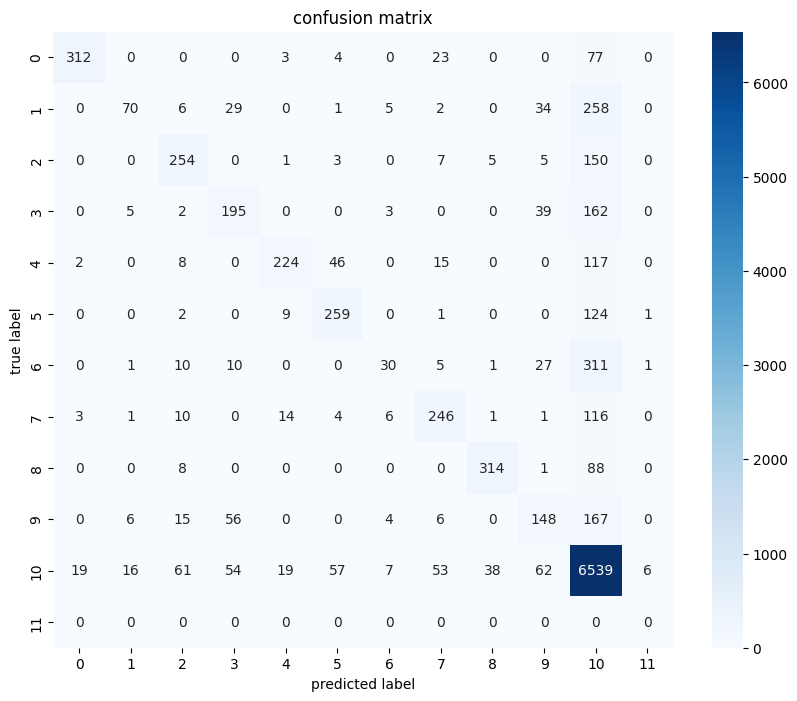

plot displayed.


In [ ]:
checkpoint = torch.load(checkpoint_path, map_location=device)

# load the model's learned parameters
model.load_state_dict(checkpoint['model_state_dict'])

# load other info if needed (e.g., for plotting)
# train_losses = checkpoint.get('train_losses', [])
# val_losses = checkpoint.get('val_losses', [])
# print(f"model loaded. trained for {checkpoint.get('epoch', 'N/A')} epochs.")
print(f"model loaded. best val loss was: {checkpoint.get('best_val_loss', 'N/A'):.4f}")


# this disables dropout and batch normalization updates
model.eval()
print("model set to evaluation mode.")

# test run
all_preds = []
all_labels = []

# disable gradient calculations during inference
with torch.no_grad():
    # wrap test_loader in tqdm for a progress bar
    for inputs, labels in tqdm.tqdm(test_loader, desc="testing"):
        # move data to the correct device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(inputs)

        # get the predicted class (index with highest logit)
        _, predicted = torch.max(outputs.data, 1)

        # move predictions and labels to cpu to store in lists
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("evaluation complete.")



              precision    recall  f1-score   support

         yes       0.93      0.74      0.83       419
          no       0.71      0.17      0.28       405
          up       0.68      0.60      0.63       425
        down       0.57      0.48      0.52       406
        left       0.83      0.54      0.66       412
       right       0.69      0.65      0.67       396
          on       0.55      0.08      0.13       396
         off       0.69      0.61      0.65       402
        stop       0.87      0.76      0.82       411
          go       0.47      0.37      0.41       402
   _unknown_       0.81      0.94      0.87      6931
   _silence_       0.00      0.00      0.00         0

    accuracy                           0.78     11005
   macro avg       0.65      0.50      0.54     11005
weighted avg       0.77      0.78      0.76     11005



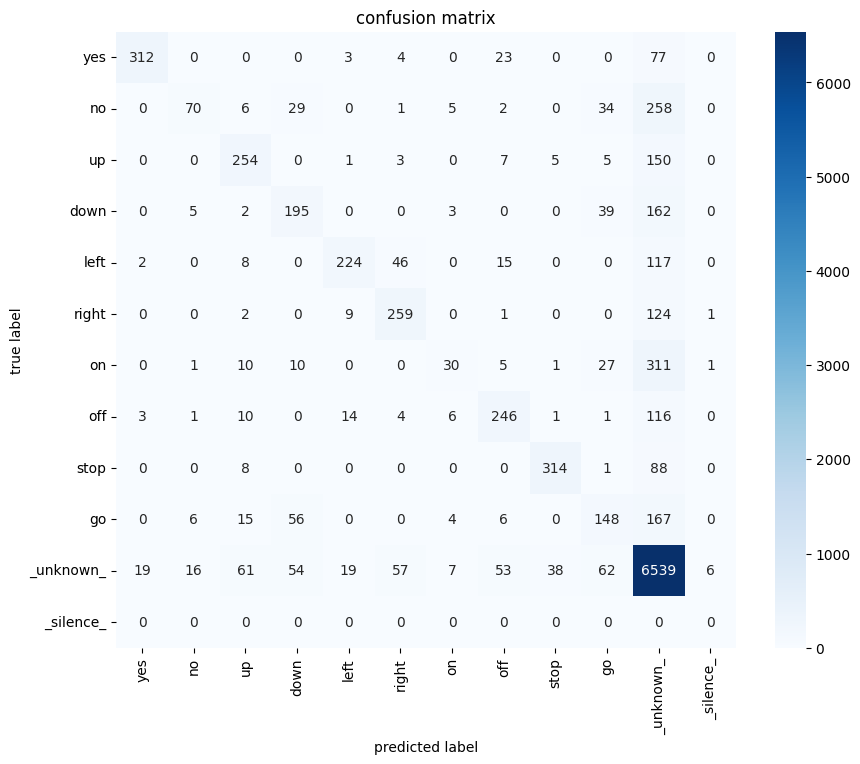

plot displayed.


In [ ]:
class_names = [
    'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
    '_unknown_', '_silence_'
]

# calculate and print per-class precision, recall, f1-score
# ensure class_names defined for proper labeling
if 'class_names' in locals() and class_names:
    report = classification_report(all_labels, all_preds, target_names=class_names, zero_division=0)
    print(report)
else:
    print("WARNING: 'class_names' list not defined. metrics will not have labels.")
    report = classification_report(all_labels, all_preds, zero_division=0)
    print(report)


# calculate confusion matrix
cm = confusion_matrix(all_labels, all_preds)


plt.figure(figsize=(10, 8))
if 'class_names' in locals() and class_names:
    # use class_names for x and y tick labels
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
else:
    print("WARNING: 'class_names' not defined. matrix will not have labels.")
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.title('confusion matrix')
plt.ylabel('true label')
plt.xlabel('predicted label')
plt.show()